**Step 1: Import all releveant libraries**

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
from copulas import *
import ndtest # bivariate Kolmogorov-Smirnov
from scipy import stats
from statsmodels.distributions.empirical_distribution import ECDF
from scipy.stats import kendalltau, pearsonr, spearmanr
from scipy.optimize import minimize
from scipy.integrate import quad
import sys
from collections import deque

plt.style.use('seaborn')
%matplotlib inline

<ipython-input-1-2c620db52b4a>:14: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


**Step 2: Load Data**

In [2]:
# Russell 2000 and S&P 400 
russell_df = yf.download('^RUT', start = '1900-01-01', end = '2023-01-18', progress = False)
sp400_df = yf.download('^SP400', start = '1900-01-01', end = '2023-01-18', progress = False)

In [3]:
russell = russell_df[['Close']]
Russell = russell.rename(columns = {'Close': 'russell_close'})

sp400 = sp400_df[['Close']]
Sp400 = sp400.rename(columns = {'Close': 'sp400_close'})

prices = pd.concat([Russell, Sp400], axis = 1)
prices = prices.dropna()
prices.head()

,russell_close,sp400_close
Date,,
1987-09-10,168.970001,90.000000
1987-09-11,170.539993,90.820000
1987-09-14,170.429993,90.910004
1987-09-15,169.199997,90.290001
1987-09-16,168.919998,90.010002


In [4]:
prices.tail()

,russell_close,sp400_close
Date,,
2023-01-10,1822.650024,2514.520020
2023-01-11,1844.050049,2545.360107
2023-01-12,1876.060059,2568.370117
2023-01-13,1887.030029,2580.909912
2023-01-17,1884.290039,2575.610107


In [5]:
# Calculate returns from the second pair: Russell_2000 and S&P_400
returns = np.log(prices).diff().dropna()

form_start = '1987-09-10'
form_end = '2013-12-31'
trade_start = '2014-01-01'
trade_end = '2023-01-18'

prices_form = prices[form_start:form_end]
prices_trade = prices[trade_start:trade_end]
returns_form = returns.loc[form_start:form_end]
returns_trade = returns.loc[trade_start:trade_end]

In [6]:
returns_form

,russell_close,sp400_close
Date,,
1987-09-11,0.009249,0.009070
1987-09-14,-0.000645,0.000991
1987-09-15,-0.007243,-0.006843
1987-09-16,-0.001656,-0.003106
1987-09-17,-0.000592,-0.003004
...,...,...
2013-12-24,0.003950,0.004115
2013-12-26,0.000731,0.000727
2013-12-27,-0.001343,0.000681


**Step 3: Calculate the Kendall's tau for our selected pair**

In [7]:
# Calculate the Kendall's tau for the second pair: 
# Russell_2000 and S&P_400
results = pd.DataFrame(columns=['tau'])
results.loc['Russell - SP400'] = stats.kendalltau(returns_form['russell_close'], returns_form['sp400_close'])[0]
print(results.loc['Russell - SP400'])

tau    0.779892
Name: Russell - SP400, dtype: float64


**Step 4: Fit marginal distribution for returns of each stock in the pair (either parametric of empirical)**

In [8]:
# We make no assumptions about the distribution of the two log-return series
x, y = returns_form['russell_close'], returns_form['sp400_close']
ecdf_x, ecdf_y  = ECDF(x), ECDF(y)
u, v = np.array([ecdf_x(a) for a in x]), np.array([ecdf_y(a) for a in y])

**Step 5: Fit copulas**

In [9]:
returns_form.head()

,russell_close,sp400_close
Date,,
1987-09-11,0.009249,0.009070
1987-09-14,-0.000645,0.000991
1987-09-15,-0.007243,-0.006843
1987-09-16,-0.001656,-0.003106
1987-09-17,-0.000592,-0.003004


In [10]:
# Convert the two returns series to two uniform values u and v using the empirical distribution functions
# Compute the Akaike Information Criterion (AIC) for different copulas and choose copula with minimum AIC
selected_pairs = ['Russell - SP400']
copulas_df = pd.DataFrame(index=selected_pairs, columns=['copula', 'parameter', 'aic', 'bic', 'KS_pvalue'])
tau = stats.kendalltau(x, y)[0]  # estimate Kendall'rank correlation
AIC ={}  # generate a dict with key being the copula family, value = [theta, AIC]
best_aic = np.inf

for copula in [GaussianCopula(), ClaytonCopula(), GumbelCopula(), FrankCopula(), JoeCopula()]:
    copula.fit(u,v)
    L = copula.log_likelihood(u,v)
    aic = 2 * copula.num_params - 2 * L
    if aic < best_aic:
        best_aic = aic
        best_bic = copula.num_params * np.log(len(u)) - 2 * L
        best_copula_name = copula.name
        best_copula = copula
            
        # calculate KS-pvalue
        smp = copula.sample(size=len(u)) # generate sample from fit copula
        s_u = smp[:,0]
        s_v = smp[:,1]
        ks_pval = ndtest.ks2d2s(u,v,s_u,s_v)
            
        if isinstance(copula, ArchimedeanCopula):
            best_param = copula.alpha
        else:
            best_param = copula.rho
            
# Choose the copula with the minimum AIC
copulas_df.loc['Russell - SP400'] = [best_copula_name, best_param, best_aic, best_bic, ks_pval]

/Users/hejifan/FRE Competition/Copula/Copula Analysis/Copulas/pairs_trading/copulas.py:171: RuntimeWarning: invalid value encountered in subtract
  n2 = np.exp(-((a**2+b**2)*self.rho**2 - 2*a*b*self.rho)/ 2*(1-self.rho**2))
/Users/hejifan/FRE Competition/Copula/Copula Analysis/Copulas/pairs_trading/copulas.py:432: RuntimeWarning: invalid value encountered in true_divide
  return (num1 * num2 * num3) / denom


In [11]:
copulas_df.head()

,copula,parameter,aic,bic,KS_pvalue
Russell - SP400,Frank,15.99799,-12952.536836,-12945.737174,0.008333


In [12]:
copulas_df['copula'].unique()

array(['Frank'], dtype=object)

Frank seems to fit data quite well.

**Step 5: Set the trading strategies**

In [13]:
# We make no assumptions about the distribution of the two log-return series
X, Y = returns_trade['russell_close'], returns_trade['sp400_close']
Ecdf_x, Ecdf_y  = ECDF(X), ECDF(Y)
U, V = np.array([Ecdf_x(a) for a in X]), np.array([Ecdf_y(a) for a in Y])

In [14]:
def parameter(family, tau):
    ''' Estimate the parameters for three kinds of Archimedean copulas
        according to association between Archimedean copulas and the Kendall rank correlation measure
    '''
    if  family == 'clayton':
        return 2 * tau / (1 - tau)
        
    elif family == 'frank':
        '''
        debye = quad(integrand, sys.float_info.epsilon, theta)[0]/theta  is first order Debye function
        frank_fun is the squared difference
        Minimize the frank_fun would give the parameter theta for the frank copula 
        ''' 
            
        integrand = lambda t: t / (np.exp(t) - 1)  # generate the integrand
        frank_fun = lambda theta: ((tau - 1) / 4.0  - (quad(integrand, sys.float_info.epsilon, theta)[0] / theta - 1) / theta) ** 2
            
        return minimize(frank_fun, 4, method='BFGS', tol=1e-5).x 
        
    elif family == 'gumbel':
        return 1 / (1 - tau)

In [15]:
def misprice_index(family, theta, u, v):
        '''Calculate mispricing index for every day in the trading period by using estimated copula
        Mispricing indices are the conditional probability P(U < u | V = v) and P(V < v | U = u)'''
        
        if family == 'clayton':
            MI_u_v = v ** (-theta - 1) * (u ** (-theta) + v ** (-theta) - 1) ** (-1 / theta - 1) # P(U<u|V=v)
            MI_v_u = u ** (-theta - 1) * (u ** (-theta) + v ** (-theta) - 1) ** (-1 / theta - 1) # P(V<v|U=u)
    
        elif family == 'frank':
            A = (np.exp(-theta * u) - 1) * (np.exp(-theta * v) - 1) + (np.exp(-theta * v) - 1)
            B = (np.exp(-theta * u) - 1) * (np.exp(-theta * v) - 1) + (np.exp(-theta * u) - 1)
            C = (np.exp(-theta * u) - 1) * (np.exp(-theta * v) - 1) + (np.exp(-theta) - 1)
            MI_u_v = B / C
            MI_v_u = A / C
        
        elif family == 'gumbel':
            A = (-np.log(u)) ** theta + (-np.log(v)) ** theta
            C_uv = np.exp(-A ** (1 / theta))   # C_uv is gumbel copula function C(u,v)
            MI_u_v = C_uv * (A ** ((1 - theta) / theta)) * (-np.log(v)) ** (theta - 1) * (1.0 / v)
            MI_v_u = C_uv * (A ** ((1 - theta) / theta)) * (-np.log(u)) ** (theta - 1) * (1.0 / u)
            
        return MI_u_v, MI_v_u

In [16]:
# Slicing returns
return_lst = []

cnt_year = 0
cnt_month = 0
    
lst_year = [str(num) for num in range(2013, 2024)]
lst_month = ['0' + str(num) for num in range(1, 10)]
lst_month.extend(['10', '11', '12'])

while cnt_year < len(lst_year) - 1:
    # the rolling formation period
    targeted_returns = returns.loc[lst_year[cnt_year] + '-' + lst_month[cnt_month] + '-' + '01': 
                                       lst_year[cnt_year + 1] + '-' + lst_month[cnt_month] + '-' + '01']
            
    if cnt_month >= len(lst_month) - 1:
        cnt_year += 1
        cnt_month = -1
            
    cnt_month += 1
    
    return_lst.append(targeted_returns)

In [17]:
return_lst

[            russell_close  sp400_close
 Date                                  
 2013-01-02       0.027945     0.025055
 2013-01-03      -0.000939     0.001805
 2013-01-04       0.007478     0.007471
 2013-01-07      -0.003818    -0.002674
 2013-01-08      -0.001257    -0.002700
 ...                   ...          ...
 2013-12-24       0.003950     0.004115
 2013-12-26       0.000731     0.000727
 2013-12-27      -0.001343     0.000681
 2013-12-30      -0.000431     0.001428
 2013-12-31       0.002625     0.003223
 
 [252 rows x 2 columns],
             russell_close  sp400_close
 Date                                  
 2013-02-01       0.010048     0.006950
 2013-02-04      -0.013168    -0.009412
 2013-02-05       0.009892     0.007331
 2013-02-06       0.003375     0.004556
 2013-02-07      -0.003507    -0.001541
 ...                   ...          ...
 2014-01-27      -0.014438    -0.008836
 2014-01-28       0.009276     0.009026
 2014-01-29      -0.013969    -0.010394
 2014-01-30  

In [18]:
# Deleting unnecessary last row
cnt_year = 0
cnt_month = 0

lst_year = [str(num) for num in range(2013, 2024)]
lst_month = ['0' + str(num) for num in range(1, 10)]
lst_month.extend(['10', '11', '12'])

for i in range(len(return_lst)):
    if cnt_year == len(lst_year) - 1: 
        break
    if str(return_lst[i].iloc[-1].name)[:10] == lst_year[cnt_year + 1] + '-' + lst_month[cnt_month] + '-' + '01':
        return_lst[i].drop(return_lst[i].tail(1).index, inplace=True)
    
    if cnt_month >= len(lst_month) - 1:
        cnt_year += 1
        cnt_month = -1
            
    cnt_month += 1
    

        
return_lst

<ipython-input-18-bfb19dd82704>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return_lst[i].drop(return_lst[i].tail(1).index, inplace=True)


[            russell_close  sp400_close
 Date                                  
 2013-01-02       0.027945     0.025055
 2013-01-03      -0.000939     0.001805
 2013-01-04       0.007478     0.007471
 2013-01-07      -0.003818    -0.002674
 2013-01-08      -0.001257    -0.002700
 ...                   ...          ...
 2013-12-24       0.003950     0.004115
 2013-12-26       0.000731     0.000727
 2013-12-27      -0.001343     0.000681
 2013-12-30      -0.000431     0.001428
 2013-12-31       0.002625     0.003223
 
 [252 rows x 2 columns],
             russell_close  sp400_close
 Date                                  
 2013-02-01       0.010048     0.006950
 2013-02-04      -0.013168    -0.009412
 2013-02-05       0.009892     0.007331
 2013-02-06       0.003375     0.004556
 2013-02-07      -0.003507    -0.001541
 ...                   ...          ...
 2014-01-27      -0.014438    -0.008836
 2014-01-28       0.009276     0.009026
 2014-01-29      -0.013969    -0.010394
 2014-01-30  

In [19]:
def theta_hedge_estimate(return_lst):
    theta_lst = []
    hedge_lst = []
    
    
    for i in range(len(return_lst)):
        tau = stats.kendalltau(return_lst[i]['russell_close'], return_lst[i]['sp400_close'])[0]
        theta = parameter('frank', tau)
        x, y = return_lst[i]['russell_close'], return_lst[i]['sp400_close']
        hedge_ratio = stats.linregress(x, y).slope
        theta_lst.append(theta)
        hedge_lst.append(hedge_ratio)
        
    theta, hedge= theta_lst[:109], hedge_lst[:109]        
        
    return theta, hedge

In [20]:
def returns_sub_interval(probs_1, probs_2, hedge_ratio, targeted_returns):
    s1, s2 = 'russell_close', 'sp400_close'
    probs_trade = pd.DataFrame(np.vstack([probs_1, probs_2]).T, index=targeted_returns.index, columns=[s1, s2])
    positions = pd.DataFrame(index=probs_trade.index, columns=probs_trade.columns)
    
    cl = 0.95 # confidence level
    
    long = False
    short = False
    
    for t in positions.index:
        # if long position is open
        if long:
            if (probs_trade.loc[t][s1] > 0.4) or (probs_trade.loc[t][s2] < 0.6):
                positions.loc[t] = [0,0]
                long = False
            else:
                positions.loc[t] = [1,-hedge_ratio]
        # if short position is open
        elif short:
            if (probs_trade.loc[t][s1] < 0.6) or (probs_trade.loc[t][s2] > 0.4):
                positions.loc[t] = [0,0]
                short = False
            else:
                positions.loc[t] = [-1,hedge_ratio]
                                    
        # if no positions are open
        else:
            if (probs_trade.loc[t][s1] < (1-cl)) and (probs_trade.loc[t][s2] > cl):
                # open long position
                positions.loc[t] = [1, -hedge_ratio]
                long = True
            elif (probs_trade.loc[t][s1] > cl) and (probs_trade.loc[t][s2] < (1-cl)):
                # open short positions
                positions.loc[t] = [-1, hedge_ratio]
                short = True
            else:
                positions.loc[t] = [0,0]
    # calculate returns
    algo_ret = (targeted_returns * positions.shift()).sum(axis=1)
    
    return algo_ret

In [21]:
theta, hedge = theta_hedge_estimate(return_lst)
len(theta)

109

In [22]:
u = pd.DataFrame(U, index = returns_trade.index)
v = pd.DataFrame(V, index = returns_trade.index)

# slicing u, v
cnt_year = 0
cnt_month = 0

u_v_lst = []
lst_year = [str(num) for num in range(2014, 2024)]
lst_month = ['0' + str(num) for num in range(1, 10)]
lst_month.extend(['10', '11', '12'])

while cnt_year < len(lst_year) - 1:
    # the rolling formation period
    
    u_specific = u.loc[lst_year[cnt_year] + '-' + lst_month[cnt_month] + '-' + '01': 
                                       lst_year[cnt_year] + '-' + lst_month[cnt_month + 1] + '-' + '01']
    v_specific = v.loc[lst_year[cnt_year] + '-' + lst_month[cnt_month] + '-' + '01': 
                                       lst_year[cnt_year] + '-' + lst_month[cnt_month + 1] + '-' + '01']
    
    u_v_lst.append((u_specific, v_specific))
    
    if cnt_month >= len(lst_month) - 2:
        u_12 = u.loc[lst_year[cnt_year] + '-' + lst_month[cnt_month + 1] + '-' + '01': 
                                       lst_year[cnt_year] + '-' + lst_month[cnt_month + 1] + '-' + '31']
        v_12 = v.loc[lst_year[cnt_year] + '-' + lst_month[cnt_month + 1] + '-' + '01': 
                                       lst_year[cnt_year] + '-' + lst_month[cnt_month + 1] + '-' + '31']
        u_v_lst.append((u_12, v_12))
        cnt_year += 1
        cnt_month = -1
            
    cnt_month += 1
    
# Adding the last month period 
u_last = u.loc['2023-01-01':]
v_last = v.loc['2023-01-01':]

u_v_lst.append((u_last, v_last))

len(u_v_lst)
    

109

In [23]:
u_v_lst

[(                   0
  Date                
  2014-01-02  0.160808
  2014-01-03  0.655975
  2014-01-06  0.221002
  2014-01-07  0.786467
  2014-01-08  0.464411
  2014-01-09  0.498243
  2014-01-10  0.678383
  2014-01-13  0.118190
  2014-01-14  0.873023
  2014-01-15  0.723199
  2014-01-16  0.528120
  2014-01-17  0.328207
  2014-01-21  0.709139
  2014-01-22  0.658612
  2014-01-23  0.225395
  2014-01-24  0.039104
  2014-01-27  0.115114
  2014-01-28  0.791301
  2014-01-29  0.120387
  2014-01-30  0.891916
  2014-01-31  0.227153,
                     0
  Date                
  2014-01-02  0.132689
  2014-01-03  0.654218
  2014-01-06  0.219244
  2014-01-07  0.805360
  2014-01-08  0.533831
  2014-01-09  0.522408
  2014-01-10  0.756591
  2014-01-13  0.084798
  2014-01-14  0.888401
  2014-01-15  0.719244
  2014-01-16  0.409051
  2014-01-17  0.324253
  2014-01-21  0.637961
  2014-01-22  0.683216
  2014-01-23  0.171353
  2014-01-24  0.030316
  2014-01-27  0.166960
  2014-01-28  0.817223
  2014-01-

In [24]:
str(u_v_lst[0][0].iloc[-1].name)[:10]

'2014-01-31'

In [25]:
# deleting the first day of the new months if it is contained in the last row of each element of the list
cnt_year = 0
cnt_month = 0

lst_year = [str(num) for num in range(2014, 2024)]
lst_month = ['0' + str(num) for num in range(1, 10)]
lst_month.extend(['10', '11', '12'])

for i in range(len(u_v_lst)):
    if str(u_v_lst[i][0].iloc[-1].name)[:10] == lst_year[cnt_year] + '-' + lst_month[cnt_month + 1] + '-' + '01':
        u_v_lst[i][0].drop(u_v_lst[i][0].tail(1).index, inplace=True)
    if str(u_v_lst[i][1].iloc[-1].name)[:10] == lst_year[cnt_year] + '-' + lst_month[cnt_month + 1] + '-' + '01':
        u_v_lst[i][1].drop(u_v_lst[i][1].tail(1).index, inplace=True)
        
    if cnt_month >= len(lst_month) - 2:
        
        cnt_year += 1
        cnt_month = -2
            
    cnt_month += 1
        
u_v_lst

<ipython-input-25-40fff2e85e0f>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_v_lst[i][0].drop(u_v_lst[i][0].tail(1).index, inplace=True)
<ipython-input-25-40fff2e85e0f>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u_v_lst[i][1].drop(u_v_lst[i][1].tail(1).index, inplace=True)


[(                   0
  Date                
  2014-01-02  0.160808
  2014-01-03  0.655975
  2014-01-06  0.221002
  2014-01-07  0.786467
  2014-01-08  0.464411
  2014-01-09  0.498243
  2014-01-10  0.678383
  2014-01-13  0.118190
  2014-01-14  0.873023
  2014-01-15  0.723199
  2014-01-16  0.528120
  2014-01-17  0.328207
  2014-01-21  0.709139
  2014-01-22  0.658612
  2014-01-23  0.225395
  2014-01-24  0.039104
  2014-01-27  0.115114
  2014-01-28  0.791301
  2014-01-29  0.120387
  2014-01-30  0.891916
  2014-01-31  0.227153,
                     0
  Date                
  2014-01-02  0.132689
  2014-01-03  0.654218
  2014-01-06  0.219244
  2014-01-07  0.805360
  2014-01-08  0.533831
  2014-01-09  0.522408
  2014-01-10  0.756591
  2014-01-13  0.084798
  2014-01-14  0.888401
  2014-01-15  0.719244
  2014-01-16  0.409051
  2014-01-17  0.324253
  2014-01-21  0.637961
  2014-01-22  0.683216
  2014-01-23  0.171353
  2014-01-24  0.030316
  2014-01-27  0.166960
  2014-01-28  0.817223
  2014-01-

In [26]:
type(u_v_lst[0][0])

pandas.core.frame.DataFrame

In [27]:
# slicing returns among returns_trade
cnt_year = 0
cnt_month = 0

returns_lst = []
lst_year = [str(num) for num in range(2014, 2024)]
lst_month = ['0' + str(num) for num in range(1, 10)]
lst_month.extend(['10', '11', '12'])

while cnt_year < len(lst_year) - 1:
    # the rolling formation period
    
    returns_1 = returns_trade.loc[lst_year[cnt_year] + '-' + lst_month[cnt_month] + '-' + '01': 
                                       lst_year[cnt_year] + '-' + lst_month[cnt_month + 1] + '-' + '01']['russell_close']
    returns_2 = returns_trade.loc[lst_year[cnt_year] + '-' + lst_month[cnt_month] + '-' + '01': 
                                       lst_year[cnt_year] + '-' + lst_month[cnt_month + 1] + '-' + '01']['sp400_close']
    ret1 = pd.DataFrame(returns_1)
    ret2 = pd.DataFrame(returns_2)
    
    returns_lst.append((ret1, ret2))
    
    if cnt_month >= len(lst_month) - 2:
        return1 = returns_trade.loc[lst_year[cnt_year] + '-' + lst_month[cnt_month + 1] + '-' + '01': 
                                       lst_year[cnt_year] + '-' + lst_month[cnt_month + 1] + '-' + '31']['russell_close']
        return2 = returns_trade.loc[lst_year[cnt_year] + '-' + lst_month[cnt_month + 1] + '-' + '01': 
                                       lst_year[cnt_year] + '-' + lst_month[cnt_month + 1] + '-' + '31']['sp400_close']
        
        ret_1 = pd.DataFrame(return1)
        ret_2 = pd.DataFrame(return2)
        
        returns_lst.append((ret_1, ret_2))
        cnt_year += 1
        cnt_month = -1
            
    cnt_month += 1
    
# Adding the last month period 
returns_last1 = returns_trade.loc['2023-01-01':]['russell_close']
returns_last2 = returns_trade.loc['2023-01-01':]['sp400_close']

returns_lst.append((returns_last1, returns_last2))

In [28]:
type(returns_lst[0][0])

pandas.core.frame.DataFrame

In [29]:
returns_lst

[(            russell_close
  Date                     
  2014-01-02      -0.011165
  2014-01-03       0.004656
  2014-01-06      -0.007754
  2014-01-07       0.009085
  2014-01-08      -0.000147
  2014-01-09       0.000769
  2014-01-10       0.005321
  2014-01-13      -0.014218
  2014-01-14       0.013273
  2014-01-15       0.006784
  2014-01-16       0.001518
  2014-01-17      -0.004014
  2014-01-21       0.006220
  2014-01-22       0.004726
  2014-01-23      -0.007554
  2014-01-24      -0.024408
  2014-01-27      -0.014438
  2014-01-28       0.009276
  2014-01-29      -0.013969
  2014-01-30       0.014953
  2014-01-31      -0.007471,
              sp400_close
  Date                   
  2014-01-02    -0.010709
  2014-01-03     0.004170
  2014-01-06    -0.006446
  2014-01-07     0.008543
  2014-01-08     0.001443
  2014-01-09     0.001127
  2014-01-10     0.006746
  2014-01-13    -0.014349
  2014-01-14     0.012115
  2014-01-15     0.005682
  2014-01-16    -0.001249
  2014-01-17    -

In [30]:
returns_lst[0][0]

,russell_close
Date,
2014-01-02,-0.011165
2014-01-03,0.004656
2014-01-06,-0.007754
2014-01-07,0.009085
2014-01-08,-0.000147
2014-01-09,0.000769
2014-01-10,0.005321
2014-01-13,-0.014218
2014-01-14,0.013273


In [31]:
# deleting the first day of the new months if it is contained in the last row of each element of the list
cnt_year = 0
cnt_month = 0

lst_year = [str(num) for num in range(2014, 2024)]
lst_month = ['0' + str(num) for num in range(1, 10)]
lst_month.extend(['10', '11', '12'])

for i in range(len(returns_lst)):
    returns_lst[i] = list(returns_lst[i])
    returns_lst[i][0] = pd.DataFrame(returns_lst[i][0])
    returns_lst[i][1] = pd.DataFrame(returns_lst[i][1])
        
    if str(returns_lst[i][0].iloc[-1].name)[:10] == lst_year[cnt_year] + '-' + lst_month[cnt_month + 1] + '-' + '01':
        returns_lst[i][0].drop(returns_lst[i][0].tail(1).index, inplace=True)
    if str(returns_lst[i][1].iloc[-1].name)[:10] == lst_year[cnt_year] + '-' + lst_month[cnt_month + 1] + '-' + '01':
        returns_lst[i][1].drop(returns_lst[i][1].tail(1).index, inplace=True)
        
    if cnt_month >= len(lst_month) - 2:
        
        cnt_year += 1
        cnt_month = -2
            
    cnt_month += 1
        
returns_lst

[[            russell_close
  Date                     
  2014-01-02      -0.011165
  2014-01-03       0.004656
  2014-01-06      -0.007754
  2014-01-07       0.009085
  2014-01-08      -0.000147
  2014-01-09       0.000769
  2014-01-10       0.005321
  2014-01-13      -0.014218
  2014-01-14       0.013273
  2014-01-15       0.006784
  2014-01-16       0.001518
  2014-01-17      -0.004014
  2014-01-21       0.006220
  2014-01-22       0.004726
  2014-01-23      -0.007554
  2014-01-24      -0.024408
  2014-01-27      -0.014438
  2014-01-28       0.009276
  2014-01-29      -0.013969
  2014-01-30       0.014953
  2014-01-31      -0.007471,
              sp400_close
  Date                   
  2014-01-02    -0.010709
  2014-01-03     0.004170
  2014-01-06    -0.006446
  2014-01-07     0.008543
  2014-01-08     0.001443
  2014-01-09     0.001127
  2014-01-10     0.006746
  2014-01-13    -0.014349
  2014-01-14     0.012115
  2014-01-15     0.005682
  2014-01-16    -0.001249
  2014-01-17    -

In [32]:
# Create a big list containing all sub pandas dataframe
whole_return_lst = []
s1, s2 = 'russell_close', 'sp400_close'
for i in range(len(returns_lst)):
    return1 = np.array(returns_lst[i][0]).T
    return2 = np.array(returns_lst[i][1]).T
    pd_dataframe = pd.DataFrame(np.vstack([return1, return2]).T, index=u_v_lst[i][0].index, columns=[s1, s2])
    # pd_dataframe = pd.DataFrame([np.array(returns_lst[i][0]).T, np.array(returns_lst[i][1]).T]).T, 
    # index=returns_lst[i][0].index, columns=[s1, s2])
    
    
    whole_return_lst.append(pd_dataframe)


In [33]:
whole_return_lst

[            russell_close  sp400_close
 Date                                  
 2014-01-02      -0.011165    -0.010709
 2014-01-03       0.004656     0.004170
 2014-01-06      -0.007754    -0.006446
 2014-01-07       0.009085     0.008543
 2014-01-08      -0.000147     0.001443
 2014-01-09       0.000769     0.001127
 2014-01-10       0.005321     0.006746
 2014-01-13      -0.014218    -0.014349
 2014-01-14       0.013273     0.012115
 2014-01-15       0.006784     0.005682
 2014-01-16       0.001518    -0.001249
 2014-01-17      -0.004014    -0.003148
 2014-01-21       0.006220     0.003792
 2014-01-22       0.004726     0.004771
 2014-01-23      -0.007554    -0.008518
 2014-01-24      -0.024408    -0.025396
 2014-01-27      -0.014438    -0.008836
 2014-01-28       0.009276     0.009026
 2014-01-29      -0.013969    -0.010394
 2014-01-30       0.014953     0.013888
 2014-01-31      -0.007471    -0.004438,
             russell_close  sp400_close
 Date                                  

In [34]:
# calculate positions
algo_returns = {}
s1, s2 = 'russell_close', 'sp400_close'
cl = 0.95 # confidence level

for i in range(len(u_v_lst)):
    theta_i = theta[i]
    prob_s1, prob_s2 = misprice_index('frank', theta_i, u_v_lst[i][0], u_v_lst[i][1])
    
    prob_s1, prob_s2 = np.array(prob_s1).T, np.array(prob_s2).T
    
    probs_trade = pd.DataFrame(np.vstack([prob_s1, prob_s2]).T, index=u_v_lst[i][0].index, columns=[s1, s2])
    positions = pd.DataFrame(index=probs_trade.index, columns=probs_trade.columns)

    long = False
    short = False
    for t in positions.index:    
        # if long position is open
        if long:
            if (probs_trade.loc[t][s1] > 0.4) or (probs_trade.loc[t][s2] < 0.6):
                positions.loc[t] = [0,0]
                long = False
            else:
                positions.loc[t] = [1,-hedge[i]]
        # if short position is open
        elif short:
            if (probs_trade.loc[t][s1] < 0.6) or (probs_trade.loc[t][s2] > 0.4):
                positions.loc[t] = [0,0]
                short = False
            else:
                positions.loc[t] = [-1,hedge[i]]

        # if no positions are open
        else:
            if (probs_trade.loc[t][s1] < (1-cl)) and (probs_trade.loc[t][s2] > cl):
                # open long position
                positions.loc[t] = [1, -hedge[i]]
                long = True
            elif (probs_trade.loc[t][s1] > cl) and (probs_trade.loc[t][s2] < (1-cl)):
                # open short positions
                positions.loc[t] = [-1, hedge[i]]
                short = True
            else:
                positions.loc[t] = [0,0]
    # calculate returns
    algo_ret = (whole_return_lst[i] * positions.shift()).sum(axis=1)
    
    if 'Russell - SP400' not in algo_returns:
        algo_returns['Russell - SP400'] = algo_ret  
        
    else:
        algo_returns['Russell - SP400'] = algo_returns['Russell - SP400'].append(algo_ret)
        
algo_returns

<ipython-input-34-750ae423d4b7>:52: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  algo_returns['Russell - SP400'] = algo_returns['Russell - SP400'].append(algo_ret)
<ipython-input-34-750ae423d4b7>:52: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  algo_returns['Russell - SP400'] = algo_returns['Russell - SP400'].append(algo_ret)
<ipython-input-34-750ae423d4b7>:52: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  algo_returns['Russell - SP400'] = algo_returns['Russell - SP400'].append(algo_ret)
<ipython-input-34-750ae423d4b7>:52: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  algo_returns['Russell - SP400'] = algo_returns['Russell - SP400

{'Russell - SP400': Date
 2014-01-02    0.0
 2014-01-03    0.0
 2014-01-06   -0.0
 2014-01-07    0.0
 2014-01-08    0.0
              ... 
 2023-01-10    0.0
 2023-01-11    0.0
 2023-01-12    0.0
 2023-01-13    0.0
 2023-01-17   -0.0
 Length: 2276, dtype: float64}

**Step 6: Backtesting**

In [35]:
algo_returns

{'Russell - SP400': Date
 2014-01-02    0.0
 2014-01-03    0.0
 2014-01-06   -0.0
 2014-01-07    0.0
 2014-01-08    0.0
              ... 
 2023-01-10    0.0
 2023-01-11    0.0
 2023-01-12    0.0
 2023-01-13    0.0
 2023-01-17   -0.0
 Length: 2276, dtype: float64}

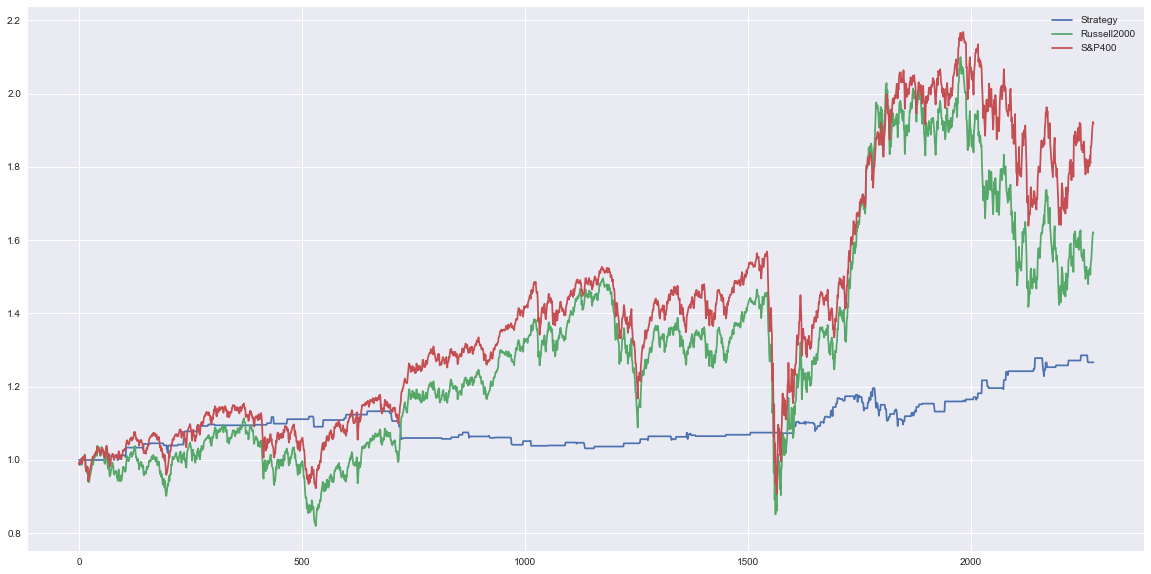

In [36]:
# Comparison with the usual buy-hold strategy for Russell_2000 and S&P_400 (simple return)
subprices = prices.loc['2013-12-31':]
returns = pd.DataFrame.from_dict(algo_returns)
returns = np.exp(returns) - 1 # convert log-returns to simple returns
total_ret = returns.sum(axis=1) / len(returns.columns) * 2 # double capital (from short positions)

buy_hold1 = subprices['russell_close'].pct_change().dropna()
buy_hold2 = subprices['sp400_close'].pct_change().dropna()


plt.figure(figsize=(20,10))
plt.plot(np.nancumprod(total_ret + 1), label='Strategy')
plt.plot(np.nancumprod(buy_hold1 + 1), label='Russell2000')
plt.plot(np.nancumprod(buy_hold2 + 1), label='S&P400')
plt.legend()

[*********************100%***********************]  1 of 1 completed


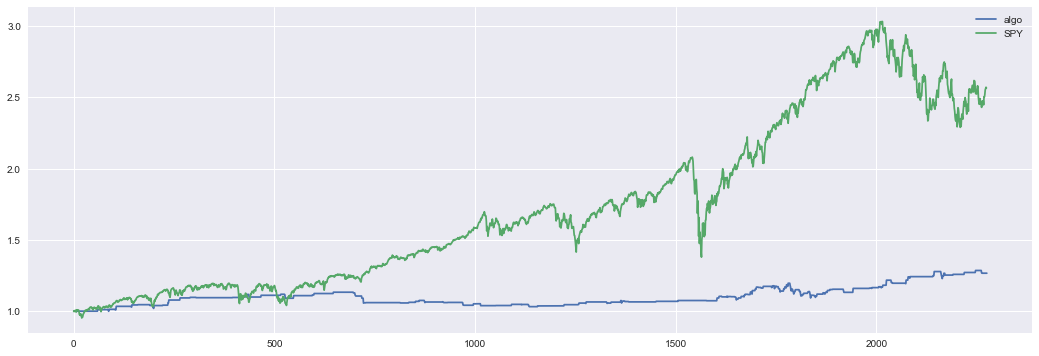

In [37]:
spy_price = yf.download('SPY', start=trade_start, end=trade_end)
spy_price = spy_price['Adj Close']
spy_ret = spy_price.pct_change().dropna()

plt.figure(figsize=(18,6))
plt.plot(np.nancumprod(total_ret + 1), label='algo')
plt.plot(np.nancumprod(spy_ret + 1), label='SPY')
plt.legend()

In [38]:
returns['total_ret'] = total_ret
returns['cum_ret'] = np.nancumprod(total_ret + 1)
returns['RUT_ret'] = np.nancumprod(buy_hold1 + 1)
returns['SP400_ret'] = np.nancumprod(buy_hold2 + 1)

In [39]:
returns


,Russell - SP400,total_ret,cum_ret,RUT_ret,SP400_ret
Date,,,,,
2014-01-02,0.0,0.0,1.000000,0.988897,0.989348
2014-01-03,0.0,0.0,1.000000,0.993512,0.993482
2014-01-06,0.0,0.0,1.000000,0.985838,0.987099
2014-01-07,0.0,0.0,1.000000,0.994835,0.995568
2014-01-08,0.0,0.0,1.000000,0.994689,0.997006
...,...,...,...,...,...
2023-01-10,0.0,0.0,1.266384,1.566335,1.872971
2023-01-11,0.0,0.0,1.266384,1.584726,1.895943
2023-01-12,0.0,0.0,1.266384,1.612234,1.913082


In [40]:
import pyfolio as pf

/Users/hejifan/anaconda3/lib/python3.8/site-packages/pyfolio/pos.py:26: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  warnings.warn(


/Users/hejifan/anaconda3/lib/python3.8/site-packages/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()
/Users/hejifan/anaconda3/lib/python3.8/site-packages/empyrical/stats.py:1527: RuntimeWarning: invalid value encountered in double_scalars
  return np.abs(np.percentile(returns, 95)) / \
/Users/hejifan/anaconda3/lib/python3.8/site-packages/pyfolio/plotting.py:648: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for stat, value in perf_stats[column].iteritems():


Start date,2014-01-02
End date,2023-01-17
Total months,108
,Backtest
Annual return,2.6%
Cumulative returns,26.6%
Annual volatility,4.8%
Sharpe ratio,0.57
Calmar ratio,0.30
Stability,0.47
Max drawdown,-8.9%


/Users/hejifan/anaconda3/lib/python3.8/site-packages/pyfolio/plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])


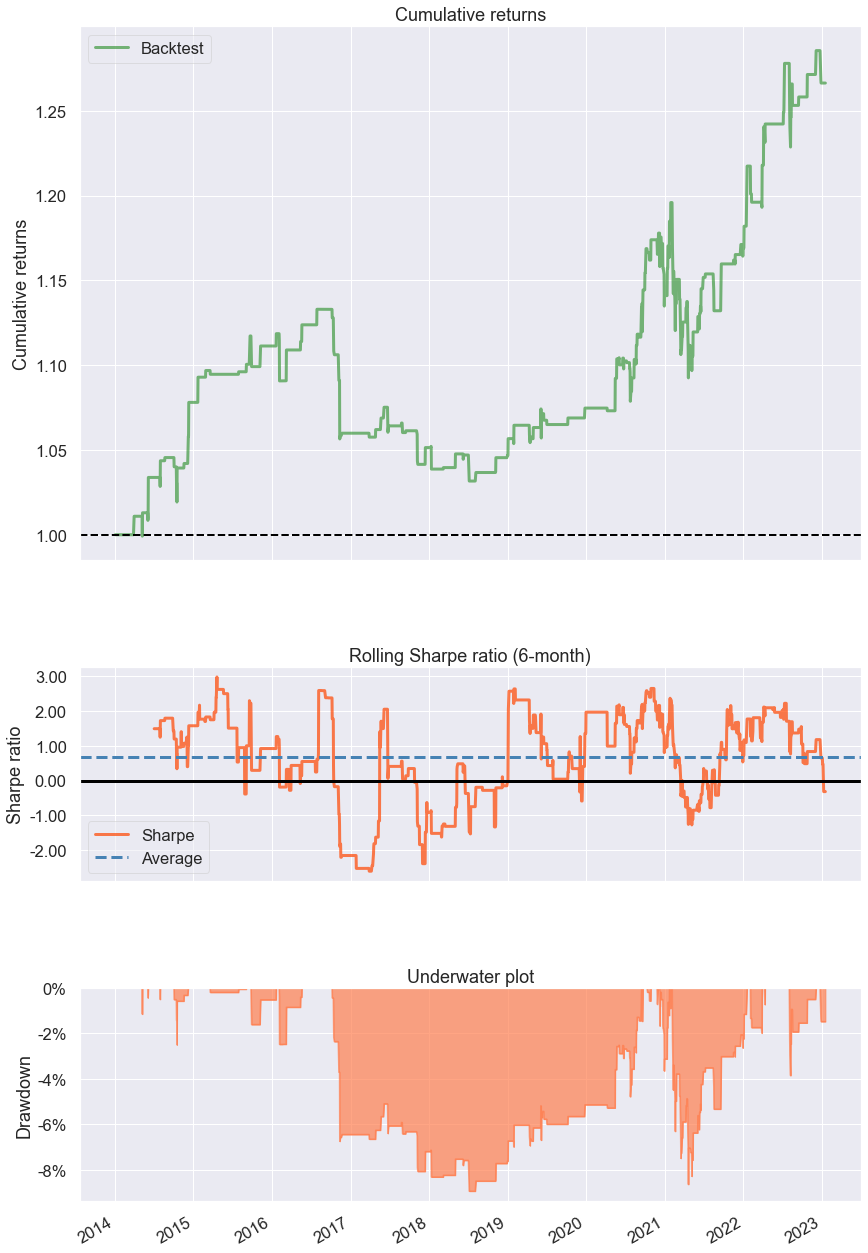

In [43]:
pf.create_simple_tear_sheet(returns['total_ret'])



In [44]:
# Write to a csv file
returns.to_csv('returns.csv')